In [1]:
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
from datetime import datetime
import os

import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import t as t_student

% matplotlib inline

In [2]:
sns.set_style('whitegrid')
sns.set_context('talk')
sns.set_palette('dark')

In [3]:
os.environ['TIINGO_API_KEY'] = 'ba62a0fba810f937382b5e772f8f152b58c4ebfc'

In [4]:
start = datetime(2005, 9, 1)
end = datetime(2019, 9, 1)
df = web.DataReader(['SPY'], 'tiingo', start, end)
df['logP'] = np.log(df['close'])

In [5]:
df.head()

adjClose    adjHigh     adjLow    adjOpen  adjVolume  \
symbol date                                                                
SPY    2005-09-01  93.126191  93.627973  92.099819  93.141397   74583200   
       2005-09-02  92.958931  93.422699  92.784067  93.399891   47658500   
       2005-09-06  94.046125  94.122153  93.247835  93.255438   57258600   
       2005-09-07  94.205783  94.373044  93.863659  93.992906   41772100   
       2005-09-08  93.894070  94.274208  93.749618  94.015714   39074300   

                    close  divCash    high     low    open  splitFactor  \
symbol date                                                               
SPY    2005-09-01  122.49      0.0  123.15  121.14  122.51          1.0   
       2005-09-02  122.27      0.0  122.88  122.04  122.85          1.0   
       2005-09-06  123.70      0.0  123.80  122.65  122.66          1.0   
       2005-09-07  123.91      0.0  124.13  123.46  123.63          1.0   
       2005-09-08  123.50      0.0  124.00  123.31  123.66          1.0   

                     volume      logP  
symbol date                            
SPY    2005-09-01  74583200  4.808029  
       2005-09-02  47658500  4.806232  
       2005-09-06  57258600  4.817859  
       2005-09-07  41772100  4.819555  
       2005-09-08  39074300  4.816241

In [6]:
df['cum_rets'] = df['logP'].rolling(2).apply(lambda x: x[-1]-x[0], raw=True).dropna()
df = df.dropna()
df.head()

adjClose    adjHigh     adjLow    adjOpen  adjVolume  \
symbol date                                                                
SPY    2005-09-02  92.958931  93.422699  92.784067  93.399891   47658500   
       2005-09-06  94.046125  94.122153  93.247835  93.255438   57258600   
       2005-09-07  94.205783  94.373044  93.863659  93.992906   41772100   
       2005-09-08  93.894070  94.274208  93.749618  94.015714   39074300   
       2005-09-09  94.730373  94.836812  94.122153  94.144961   44113400   

                    close  divCash    high     low    open  splitFactor  \
symbol date                                                               
SPY    2005-09-02  122.27      0.0  122.88  122.04  122.85          1.0   
       2005-09-06  123.70      0.0  123.80  122.65  122.66          1.0   
       2005-09-07  123.91      0.0  124.13  123.46  123.63          1.0   
       2005-09-08  123.50      0.0  124.00  123.31  123.66          1.0   
       2005-09-09  124.60      0.0  124.74  123.80  123.83          1.0   

                     volume      logP  cum_rets  
symbol date                                      
SPY    2005-09-02  47658500  4.806232 -0.001798  
       2005-09-06  57258600  4.817859  0.011628  
       2005-09-07  41772100  4.819555  0.001696  
       2005-09-08  39074300  4.816241 -0.003314  
       2005-09-09  44113400  4.825109  0.008867

## Verify of the cummulative behaviour

The sum of the cum rets should always lead to the corresponding logP:

In [7]:
N = 100
assert(df.iloc[N]['logP'] == df.iloc[0]['logP'] + np.sum([df.iloc[i+1]['cum_rets'] for i in range(N)]))

# Statistical properties over time sampling

In [8]:
n_days = range(1,31)
means = []
stds = []

for n in n_days:
    real_rets = df.iloc[::n].rolling(2).apply(lambda x: x[-1]-x[0], raw=True)['logP'].dropna()
    means.append(real_rets.mean())
    stds.append(real_rets.std())

[0.0002410881420942004, 0.0004858962012272454, 0.0007288443018408681, 0.0009717924024544908, 0.0012171026990673967, 0.0014576886036817363, 0.0017039437786943552, 0.0019473977753115997, 0.0021852319787952763, 0.00243906233696061, 0.002660067822009887, 0.0029153772073634726, 0.003156446191593177, 0.0033855408643762197, 0.003658593505440915, 0.0038947955506231993, 0.0040728794935323415, 0.004299373897563403, 0.004535175781756409, 0.0046978075281054014, 0.004934682662604962, 0.005320135644019774, 0.005404652439995911, 0.005732498530084537, 0.005869721795383682, 0.006107149786537022, 0.006339299539014377, 0.0067710817287524394, 0.00704130304278478, 0.00731718701088183]


(0, 0.01)

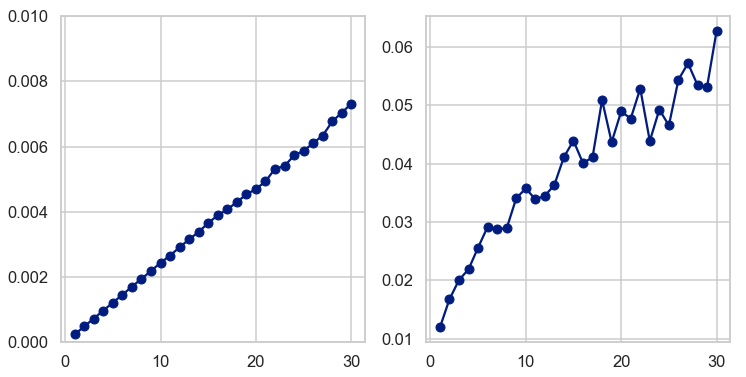

In [9]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
print(means)
    
ax[0].plot(n_days, means,'o-')
ax[1].plot(n_days, stds,'o-')
ax[0].set_ylim([0,0.01])

# Estimation

In [42]:
invariants = df['cum_rets']

In [43]:
distribution = stats.norm
sample_size=10000

In [44]:
invariants = invariants#[(invariants>invariants.quantile(0.005))&(invariants<invariants.quantile(0.995))]

In [46]:
dist_fit_params = distribution.fit(invariants)#, floc=invariants.mean())
dist_fit_params

(0.00024048815151574563, 0.011931593330457882)

In [47]:
invariants.mean(), invariants.std()

(0.00024048815151574563, 0.011933349396893245)

In [48]:
fit_sample = distribution.rvs(*dist_fit_params, size=sample_size)

In [49]:
fit_sample.mean()

0.00015016480617940418

(-0.02, 0.02)

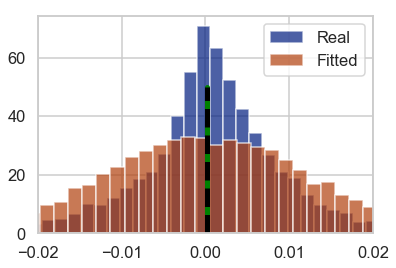

In [50]:
fig = plt.figure()
plt.hist(invariants, bins=150, normed=True, alpha=0.7, label='Real')
plt.hist(fit_sample[(fit_sample>min(invariants))*(fit_sample<max(invariants))], bins=50, normed=True, alpha=0.7, label='Fitted')
plt.xlim(min(invariants), max(invariants))
plt.legend()
plt.plot((invariants.mean(),invariants.mean()), (0,50), 'g', linewidth=5)
plt.plot((fit_sample.mean(),fit_sample.mean()), (0,50), 'k--', linewidth=5)
plt.xlim([-0.02, 0.02])

## Projection

In [51]:
sample_size = 100000
projections_df = pd.DataFrame()
days_list = list(range(1,31))+[40,120]
for n_days in days_list:
    projected_sample = np.zeros(sample_size)
    for k in range(n_days):
        projected_sample += distribution.rvs(*dist_fit_params, size=sample_size)
    projections_df[n_days] = projected_sample

In [52]:
means = []
stds = []

for n_days in days_list:
    real_rets = df.iloc[::n_days].rolling(2).apply(lambda x: x[-1]-x[0], raw=True)['logP'].dropna()
    means.append(real_rets.mean())
    stds.append(real_rets.std())

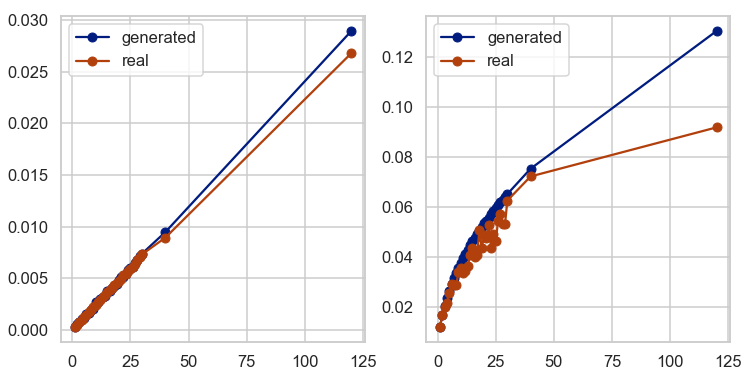

In [53]:
projections_mean = pd.DataFrame()
projections_mean['generated'] = projections_df.mean()
projections_mean['real'] = means
projections_std = pd.DataFrame()
projections_std['generated'] = projections_df.std()
projections_std['real'] = stds

fig, ax = plt.subplots(1,2,figsize=(12,6))
projections_mean.plot(style='-o', ax=ax[0])
projections_std.plot(style='-o', ax=ax[1])

In [54]:
projections_mean.head(10)

,generated,real
1,0.000232,0.000241
2,0.000605,0.000486
3,0.000732,0.000729
4,0.001072,0.000972
5,0.001120,0.001217
6,0.001544,0.001458
7,0.001648,0.001704
8,0.001955,0.001947
9,0.002011,0.002185
10,0.002661,0.002439


In [55]:
def get_slope(x):
    m,b = np.polyfit(x.index,x,1)
    return m

projections_mean.apply(get_slope)

generated    0.000241
real         0.000223
dtype: float64

### Projection over 1 month

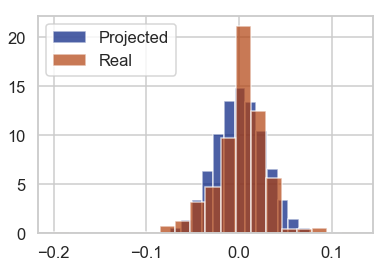

In [56]:
n_days = 5
real_rets = df.iloc[::n].rolling(2).apply(lambda x: x[-1]-x[0], raw=True)['logP'].dropna()
proj_rets = projections_df[n_days][(projections_df[n_days]<max(real_rets)) & (projections_df[n_days]>min(real_rets))]

plt.hist(proj_rets, bins=20, normed=True, alpha=0.7, label='Projected')
plt.hist(real_rets, bins=20, normed=True, alpha=0.7, label='Real')
plt.legend()

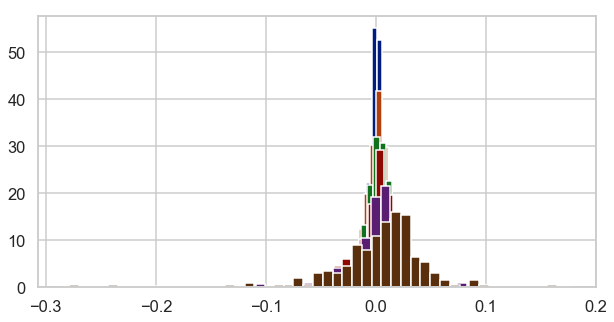

In [57]:
fig = plt.figure(figsize=(10,5))

for n_days in [1,2,3,5,10,15]:
    real_rets = df.iloc[::n_days].rolling(2).apply(lambda x: x[-1]-x[0], raw=True)['logP'].dropna()
    real_rets.hist(normed=True, bins=50)

# Projection of all

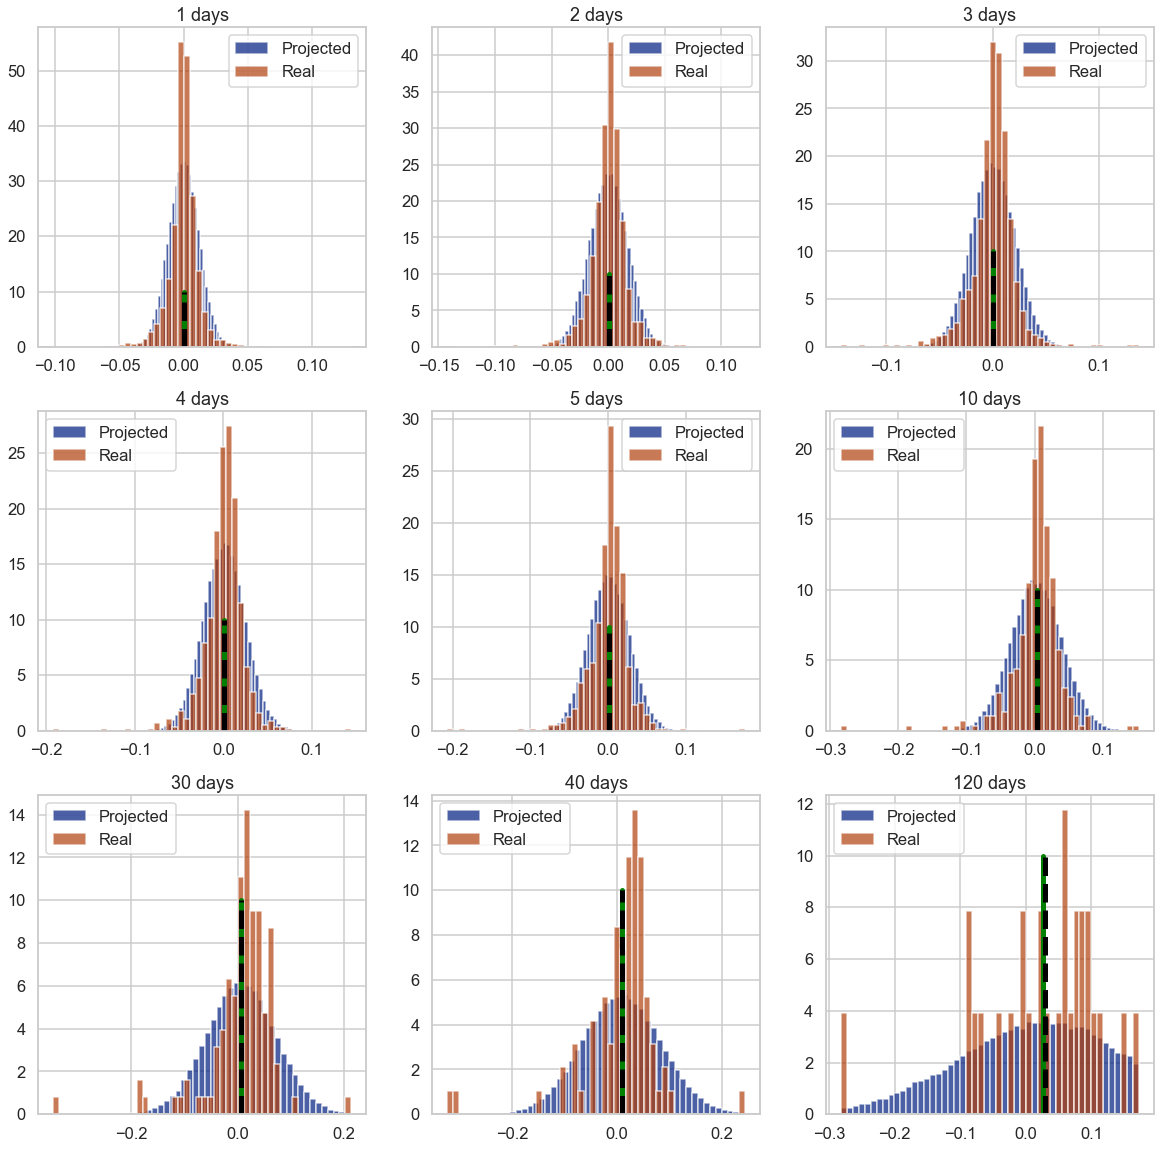

In [58]:
plotdays=[1,2,3,4,5,10,30,40,120]
fig, ax = plt.subplots(3,3, figsize=(20,20))
for n, n_days in enumerate(plotdays):
    real_rets = df.iloc[::n_days].rolling(2).apply(lambda x: x[-1]-x[0], raw=True)['logP'].dropna()
    proj_rets = projections_df[n_days]

    ax.ravel()[n].hist(proj_rets[(proj_rets<max(real_rets)) & (proj_rets>min(real_rets))], bins=50, normed=True, alpha=0.7, label='Projected')
    ax.ravel()[n].hist(real_rets, bins=50, normed=True, alpha=0.7, label='Real')
    ax.ravel()[n].plot((real_rets.mean(),real_rets.mean()), (0,10), 'g', linewidth=5)
    ax.ravel()[n].plot((proj_rets.mean(),proj_rets.mean()), (0,10), 'k--', linewidth=5)
    ax.ravel()[n].legend()
    ax.ravel()[n].set_title('%i days' % n_days)